In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Image Classification with CNN and Hyperparameter Tuning using Optuna
### Author: Bruno Kristián (2025)
**Running time: 15 minutes**

Install and import all neccessary packages

In [1]:
!pip -qqq install torch torchvision optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

Load and prepare dataset CIFAR10

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

small_train, _ = random_split(train_dataset, [30000, len(train_dataset) - 30000])
small_test, _ = random_split(test_dataset, [1000, len(test_dataset) - 1000])

train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
val_loader = DataLoader(small_test, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:14<00:00, 11.6MB/s]


A CNN model for classification with 3 convolutional and 2 fully connected layers

In [4]:
def create_model(n_channels, n_fc):
    model = nn.Sequential(
        nn.Conv2d(3, n_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(n_channels, n_channels * 2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(n_channels * 2, n_channels * 4, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear((n_channels * 4) * 4 * 4, n_fc),
        nn.ReLU(),
        nn.Linear(n_fc, 10)
    )
    return model

Objective function for Optuna hyperparameter optimization. Optuna tunes the number of channels, fully connected layer size, learning rate, and number of training epochs

In [5]:
def objective(trial):
    n_channels = trial.suggest_categorical("n_channels", [16, 32, 64])
    n_fc = trial.suggest_int("n_fc", 64, 256)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    n_epochs = trial.suggest_int("n_epochs", 10, 20)

    model = create_model(n_channels, n_fc)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(n_epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = correct / total
    return 1.0 - accuracy

Create an Optuna study and call n-times call the Optuna objective function

In [6]:
study = optuna.create_study()
study.optimize(objective, n_trials=5)

print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", 1.0 - study.best_value)

[I 2025-04-28 10:14:12,409] A new study created in memory with name: no-name-7b9d03cb-2332-45ea-b50f-eae4547bbb45
[I 2025-04-28 10:15:40,377] Trial 0 finished with value: 0.259 and parameters: {'n_channels': 64, 'n_fc': 139, 'lr': 0.0016606810502243364, 'n_epochs': 10}. Best is trial 0 with value: 0.259.
[I 2025-04-28 10:17:39,539] Trial 1 finished with value: 0.281 and parameters: {'n_channels': 64, 'n_fc': 66, 'lr': 0.0011298147396616171, 'n_epochs': 14}. Best is trial 0 with value: 0.259.
[I 2025-04-28 10:19:30,021] Trial 2 finished with value: 0.255 and parameters: {'n_channels': 64, 'n_fc': 209, 'lr': 0.0012874326174468309, 'n_epochs': 13}. Best is trial 2 with value: 0.255.
[I 2025-04-28 10:21:12,785] Trial 3 finished with value: 0.486 and parameters: {'n_channels': 64, 'n_fc': 111, 'lr': 0.004584668729097733, 'n_epochs': 12}. Best is trial 2 with value: 0.255.
[I 2025-04-28 10:22:37,925] Trial 4 finished with value: 0.921 and parameters: {'n_channels': 64, 'n_fc': 197, 'lr': 0.0

Best hyperparameters: {'n_channels': 64, 'n_fc': 209, 'lr': 0.0012874326174468309, 'n_epochs': 13}
Best validation accuracy: 0.745


Train the model with the best hyperparameters from the Optuna study

In [7]:
best_params = study.best_params
model = create_model(best_params['n_channels'], best_params['n_fc'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
epochs = best_params['n_epochs']

for i in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

Evaluate the model


Sample Predictions:


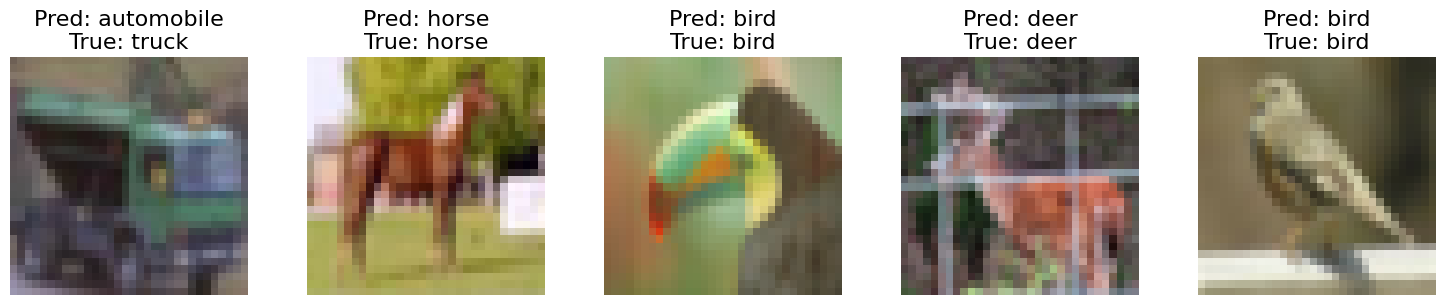

In [11]:
model.eval()
classes = train_dataset.classes
with torch.no_grad():
    inputs, targets = next(iter(val_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predicted = outputs.max(1)

print("\nSample Predictions:")

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = inputs[i].cpu()
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))

    axes[i].imshow(npimg)
    axes[i].set_title(f"Pred: {classes[predicted[i]]}\nTrue: {classes[targets[i]]}", fontsize=16)
    axes[i].axis('off')

plt.tight_layout()
plt.show()